apm 71.179.103.234_gk_model9 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            7
   Intermediates:            1
   Connections  :           32
   Equations    :            6
   Residuals    :            5
 
 Number of state variables:           2659
 Number of total equations: -         2392
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :            267
 
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipo

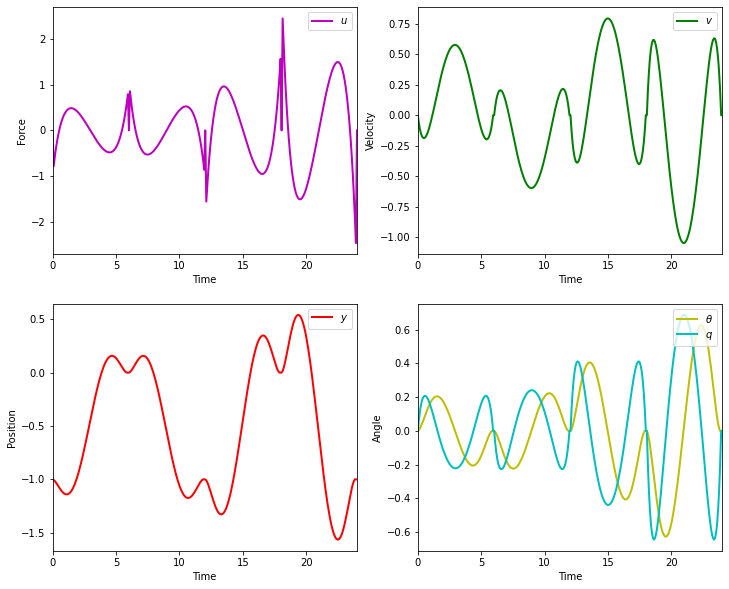

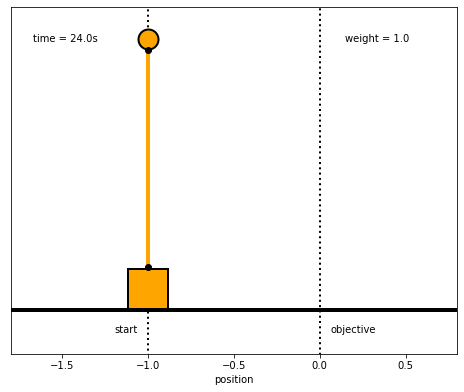

In [12]:
import matplotlib.animation as animation
import numpy as np
from gekko import GEKKO
import ffmpeg

#Defining a model
m = GEKKO()

#Defining the time, we will go beyond the 6.2s
#to check if the objective was achieved
n = 300
tf = 24.0
m.time = np.linspace(0,tf,n)
end_loc1 = int(n*6.0/tf)
end_loc2 = int(n*12.0/tf)
end_loc3 = int(n*18.0/tf)
end_loc4 = n-1 # end

#################################
#Weight of item
m2 = np.ones(n)
m2[0:end_loc1] = 0.1
m2[end_loc1:end_loc2] = 1.0
m2[end_loc2:end_loc3] = 10.0
m2[end_loc3:end_loc4] = 20.0
#################################


#Parameters
m1a = m.Param(value=10)
m2a = m.Param(value=m2)

#MV
ua = m.Var(value=0)

#State Variables
theta_a = m.Var(value=0)
qa = m.Var(value=0)
ya = m.Var(value=-1)
va = m.Var(value=0)

#Intermediates
epsilon = m.Intermediate(m2a/(m1a+m2a))

#Defining the State Space Model
m.Equation(ya.dt() == va)
m.Equation(va.dt() == -epsilon*theta_a + ua)
m.Equation(theta_a.dt() == qa)
m.Equation(qa.dt() == theta_a -ua)

#Definine the Objectives
#Make all the state variables be zero at endpoints
i = end_loc1
m.fix(ya,pos=i,val=0.0)
m.fix(va,pos=i,val=0.0)
m.fix(theta_a,pos=i,val=0.0)
m.fix(qa,pos=i,val=0.0)

i = end_loc2
m.fix(ya,pos=i,val=-1.0)
m.fix(va,pos=i,val=0.0)
m.fix(theta_a,pos=i,val=0.0)
m.fix(qa,pos=i,val=0.0)

i = end_loc3
m.fix(ya,pos=i,val=0.0)
m.fix(va,pos=i,val=0.0)
m.fix(theta_a,pos=i,val=0.0)
m.fix(qa,pos=i,val=0.0)

i = end_loc4
m.fix(ya,pos=i,val=-1.0)
m.fix(va,pos=i,val=0.0)
m.fix(theta_a,pos=i,val=0.0)
m.fix(qa,pos=i,val=0.0)

#Try to minimize change of MV over all horizon
m.Obj(0.001*ua**2)

m.options.SOLVER = 3
m.options.IMODE = 6 #MPC
m.solve() #(disp=False)

#Plotting the results
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))

plt.subplot(221)
plt.plot(m.time,ua.value,'m',lw=2)
plt.legend([r'$u$'],loc=1)
plt.ylabel('Force')
plt.xlabel('Time')
plt.xlim(m.time[0],m.time[-1])

plt.subplot(222)
plt.plot(m.time,va.value,'g',lw=2)
plt.legend([r'$v$'],loc=1)
plt.ylabel('Velocity')
plt.xlabel('Time')
plt.xlim(m.time[0],m.time[-1])

plt.subplot(223)
plt.plot(m.time,ya.value,'r',lw=2)
plt.legend([r'$y$'],loc=1)
plt.ylabel('Position')
plt.xlabel('Time')
plt.xlim(m.time[0],m.time[-1])

plt.subplot(224)
plt.plot(m.time,theta_a.value,'y',lw=2)
plt.plot(m.time,qa.value,'c',lw=2)
plt.legend([r'$\theta$',r'$q$'],loc=1)
plt.ylabel('Angle')
plt.xlabel('Time')
plt.xlim(m.time[0],m.time[-1])

plt.rcParams['animation.html'] = 'html5'

x1 = ya.value
y1 = np.zeros(len(m.time))

#suppose that l = 1
x2 = 1*np.sin(theta_a.value)+x1
x2b = 1.05*np.sin(theta_a.value)+x1
y2 = 1*np.cos(theta_a.value)-y1
y2b = 1.05*np.cos(theta_a.value)-y1

fig = plt.figure(figsize=(8,6.4))
ax = fig.add_subplot(111,autoscale_on=False,\
                     xlim=(-1.8,0.8),ylim=(-0.4,1.2))
ax.set_xlabel('position')
ax.get_yaxis().set_visible(False)

crane_rail, = ax.plot([-2.0,1.0],[-0.2,-0.2],'k-',lw=4)
start, = ax.plot([-1,-1],[-1.5,1.5],'k:',lw=2)
objective, = ax.plot([0,0],[-0.5,1.5],'k:',lw=2)
mass1, = ax.plot([],[],linestyle='None',marker='s',\
                 markersize=40,markeredgecolor='k',\
                 color='orange',markeredgewidth=2)
mass2, = ax.plot([],[],linestyle='None',marker='o',\
                 markersize=20,markeredgecolor='k',\
                 color='orange',markeredgewidth=2)
line, = ax.plot([],[],'o-',color='orange',lw=4,\
                markersize=6,markeredgecolor='k',\
                markerfacecolor='k')
time_template = 'time = %.1fs'
time_text = ax.text(0.05,0.9,'',transform=ax.transAxes)
wgt_template = 'weight = %.1f'
wgt_text = ax.text(0.75,0.9,'',transform=ax.transAxes)
start_text = ax.text(-1.06,-0.3,'start',ha='right')
end_text = ax.text(0.06,-0.3,'objective',ha='left')

def init():
    mass1.set_data([],[])
    mass2.set_data([],[])
    line.set_data([],[])
    time_text.set_text('')
    wgt_text.set_text('')
    return line, mass1, mass2, time_text, wgt_text

def animate(i):
    mass1.set_data([x1[i]],[y1[i]-0.1])
    mass2.set_data([x2b[i]],[y2b[i]])
    line.set_data([x1[i],x2[i]],[y1[i],y2[i]])
    time_text.set_text(time_template % m.time[i])
    wgt_text.set_text(wgt_template % m2[i])
    return line, mass1, mass2, time_text, wgt_text

ani_a = animation.FuncAnimation(fig, animate, \
         np.arange(1,len(m.time)), \
         interval=40,blit=False,init_func=init)

# requires ffmpeg to save mp4 file
#  available from https://ffmpeg.zeranoe.com/builds/
#  add ffmpeg.exe to path such as C:\ffmpeg\bin\ in
#  environment variables


ffmpeg
ani_a.save('Pendulum_Control.mp4',fps=30, writer = "ffmpeg")

plt.show()